In [1]:
import pandas as pd

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets

import os
import numpy as np
import matplotlib.pyplot as plt
from string import digits, punctuation
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

from google.colab import drive

# Loading data folder

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_root = '/content/drive/MyDrive/PredocData/Oralhealth'

train_root = f"{data_root}/train"
test_root = f"{data_root}/test"

In [7]:
len(os.listdir(f"{data_root}/train"))

6

# Preparing transform

In [8]:


train_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.CenterCrop((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.CenterCrop((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [9]:
train_images = datasets.ImageFolder(root = train_root, transform = train_transform)
test_images = datasets.ImageFolder(root = test_root, transform = test_transform)

In [10]:
train_labels = train_images.classes
test_labels = test_images.classes
train_labels == test_labels

True

In [11]:
train_dataloader = DataLoader(
    train_images,
    batch_size=32,
    shuffle=True
)

test_dataloader = DataLoader(
    test_images,
    batch_size=32,
    shuffle=False
)

# Building Model LeNet

In [12]:
from torchvision import models
efficient_net = models.efficientnet_b3(weights='IMAGENET1K_V1')


for param in efficient_net.features.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 60.4MB/s]


In [13]:
efficient_net.classifier = nn.Sequential(
    nn.Linear(1536, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 6)
)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cpu')

In [16]:
link = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'

In [17]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print('Exists')

else:
  print("Downloading")
  request = requests.get(link)
  with open('helper_functions.py', "wb") as f:
    f.write(request.content)


Downloading


In [18]:
from helper_functions import accuracy_fn

In [19]:
torch.manual_seed(42)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = efficient_net.classifier.parameters(), lr = 0.0001, weight_decay=0.0001)

In [20]:
from tqdm.auto import tqdm

In [21]:

torch.manual_seed(42)

epochs = 12

train_a = []
test_a = []

for epoch in tqdm(range(epochs)):
  print(f"Epochs {epoch}")
  efficient_net.train()
  train_loss, train_acc = 0,0

  for batch, (X, y) in tqdm(enumerate(train_dataloader)):
    y_pred = efficient_net(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    y_pred_class = y_pred.argmax(dim=1)
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred_class)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # if batch % 10 == 0:
    #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  efficient_net.eval()
  test_loss, test_acc = 0,0

  with torch.inference_mode():
      for X_test, y_test in tqdm(test_dataloader):
        test_pred = efficient_net(X_test)

        test_loss += loss_fn(test_pred, y_test).item()
        test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

  test_loss /= len(test_dataloader)
  test_acc /= len(test_dataloader)

  train_a.append(train_acc)
  test_a.append(test_acc)
  print(f"Train Loss : {train_loss} | Train Acc: {train_acc:.4f}")
  print(f"Test Loss: {test_loss} | Test Acc: {test_acc:.4f}")



  0%|          | 0/12 [00:00<?, ?it/s]

Epochs 0


0it [00:00, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss : 1.3097402641127782 | Train Acc: 57.9593
Test Loss: 1.2241156590290558 | Test Acc: 68.6966
Epochs 1


0it [00:00, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss : 0.8291378449339893 | Train Acc: 71.2707
Test Loss: 0.8613763921535932 | Test Acc: 72.3024
Epochs 2


0it [00:00, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss : 0.6809171143487014 | Train Acc: 75.5007
Test Loss: 0.8421971851434463 | Test Acc: 72.5427
Epochs 3


0it [00:00, ?it/s]

KeyboardInterrupt: 

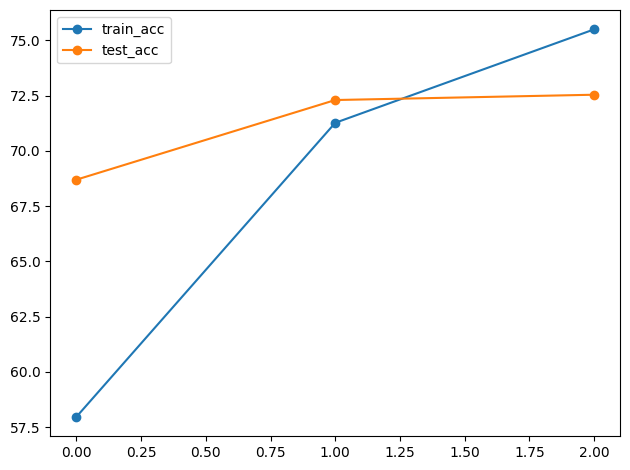

In [22]:
plt.plot(train_a, label='train_acc', marker='o')
plt.plot(test_a, label='test_acc', marker='o')

plt.tight_layout()
plt.legend()

plt.show()

In [23]:
torch.save(efficient_net.state_dict(), "efficient_net_oral_model.pth")